Datos procesados. Cohortes añadidas. Guardado en: metricas_con_cohortes.csv
------------------------------
RESUMEN DE RENDIMIENTO POR COHORTE:
                  Lesion_Recall  Lesion_Precision     FP
Cohort                                                  
ALFA (Barcelona)          0.648             0.614  0.407
RSS (Rotterdam)           0.267             0.270  2.471
SABRE (UK)                0.341             0.485  0.909


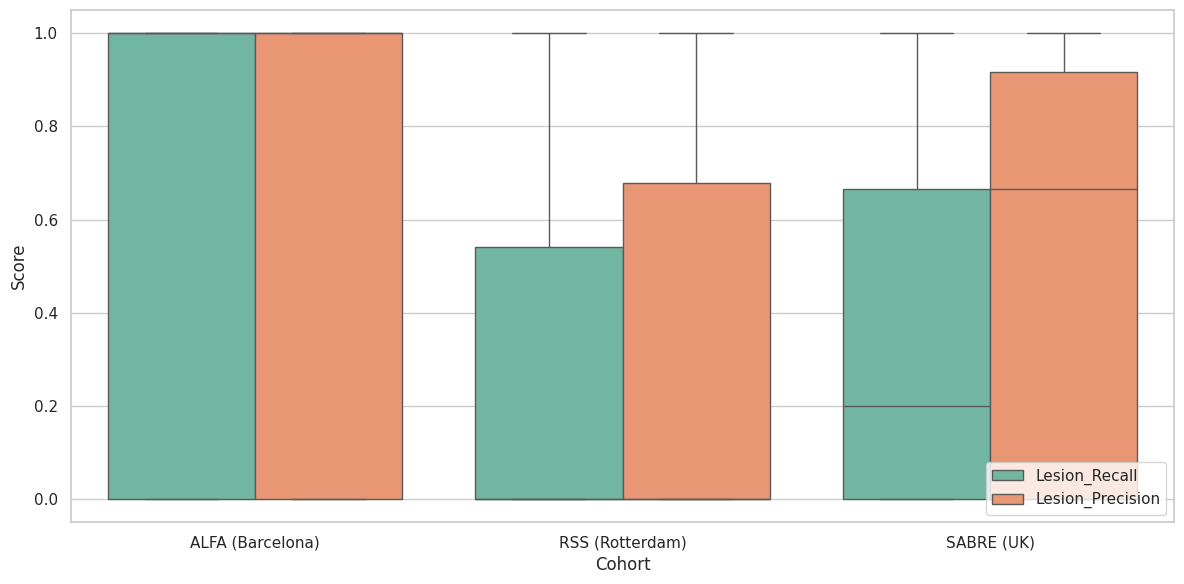

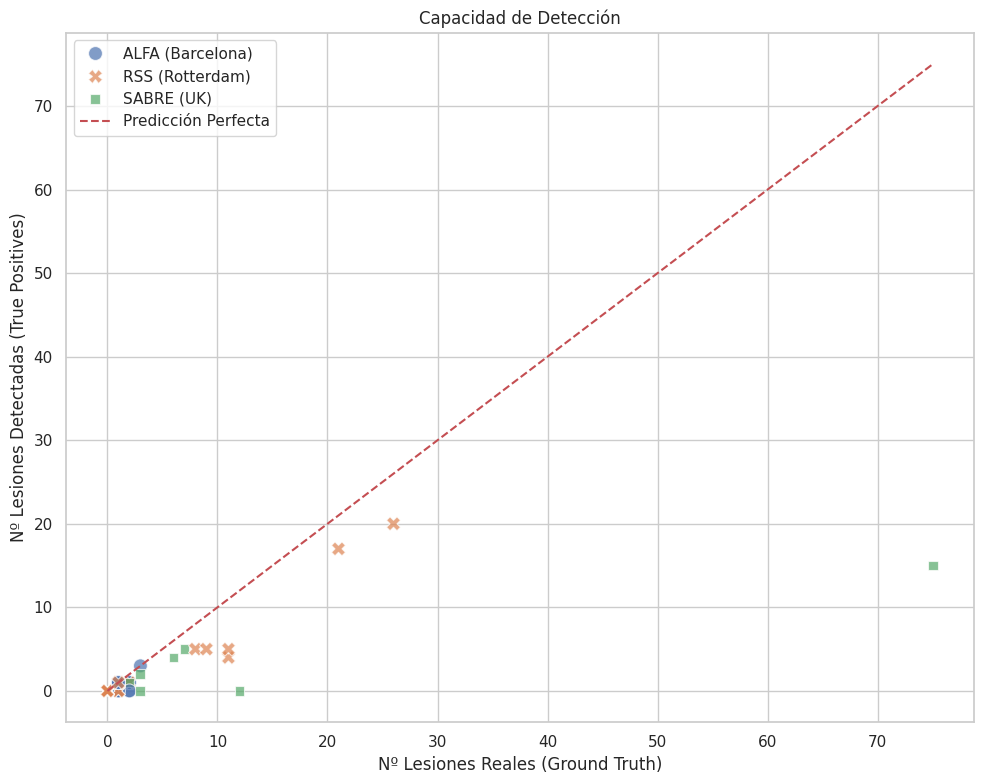

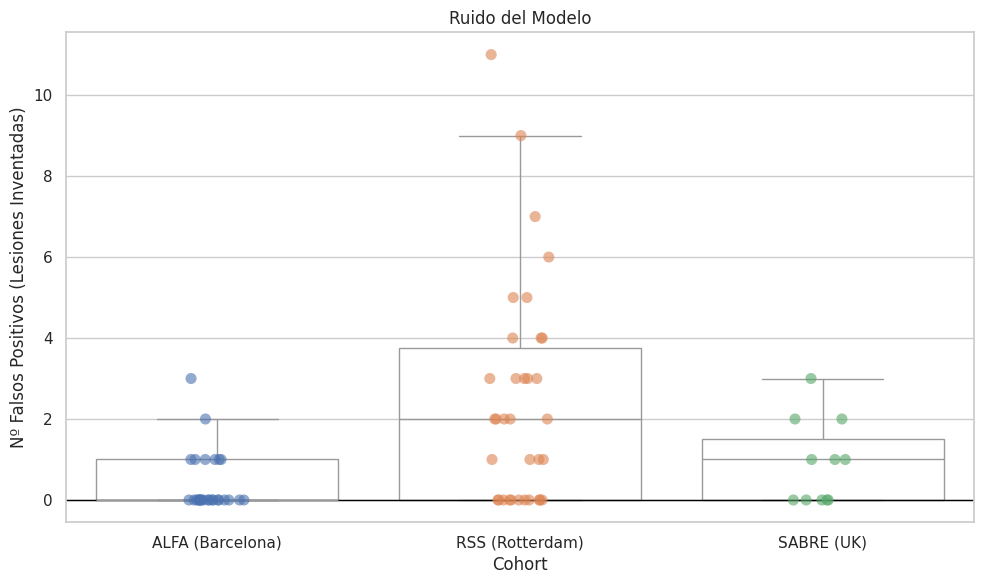

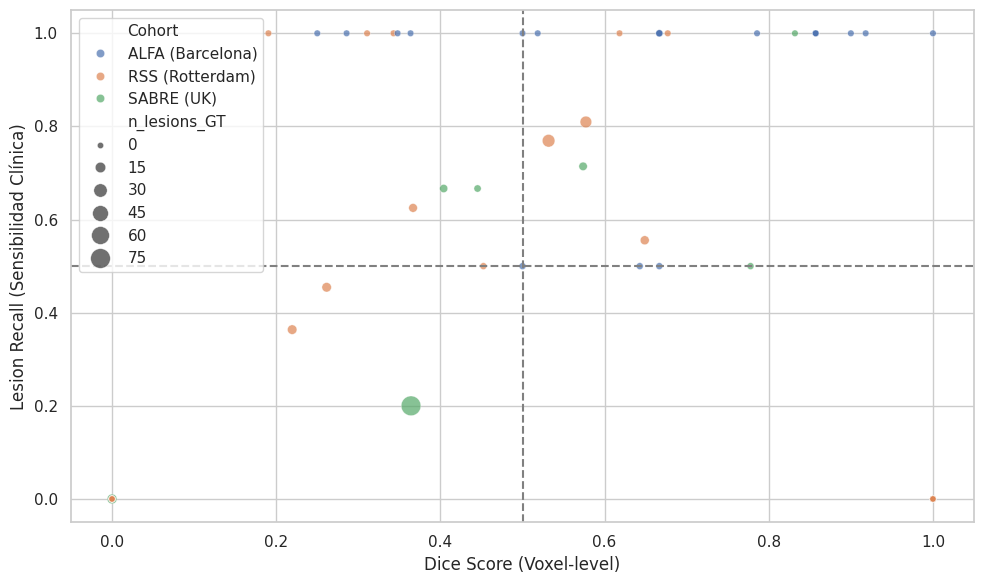

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os

# --- CONFIGURACIÓN ---
input_csv = "metricas_globales_lesiones.csv"
output_csv = "metricas_con_cohortes.csv"

# 1. CARGAR Y ENRIQUECER DATOS
if not os.path.exists(input_csv):
    print(f"ERROR: No encuentro {input_csv}. Asegúrate de que está en la misma carpeta.")
    exit()

df = pd.read_csv(input_csv)

# Función para determinar cohorte
def get_cohort(subject_id):
    try:
        # Asumiendo formato 'sub-XXX'
        parts = str(subject_id).split('-')
        if len(parts) > 1:
            num_str = parts[1]
            if num_str.startswith('1'): return "SABRE (UK)"
            if num_str.startswith('2'): return "RSS (Rotterdam)"
            if num_str.startswith('3'): return "ALFA (Barcelona)"
    except:
        pass
    return "Unknown"

# Aplicar la función
df['Cohort'] = df['case_id'].apply(get_cohort)

# Guardar el CSV enriquecido por si lo quieres usar luego
df.to_csv(output_csv, index=False)
print(f"Datos procesados. Cohortes añadidas. Guardado en: {output_csv}")
print("-" * 30)

# Imprimir resumen por Cohorte en texto
print("RESUMEN DE RENDIMIENTO POR COHORTE:")
print(df.groupby('Cohort')[['Lesion_Recall', 'Lesion_Precision', 'FP']].mean().round(3))

# --- GENERACIÓN DE GRÁFICOS ---
sns.set_theme(style="whitegrid")

# FIGURA 1: ¿Funciona igual en todos los hospitales? (Bias Check)
plt.figure(figsize=(12, 6))
# Convertimos datos a formato largo para el boxplot
df_melt = df.melt(id_vars=['Cohort'], value_vars=['Lesion_Recall', 'Lesion_Precision'], 
                  var_name='Métrica', value_name='Score')
sns.boxplot(data=df_melt, x='Cohort', y='Score', hue='Métrica', palette="Set2")
plt.ylim(-0.05, 1.05)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

# FIGURA 2: La Verdad sobre la Detección (Scatter Plot)
# Este gráfico es el más honesto. Muestra cada paciente como un punto.
plt.figure(figsize=(10, 8))
sns.scatterplot(data=df, x='n_lesions_GT', y='TP', hue='Cohort', s=100, alpha=0.7, style='Cohort')

# Línea de identidad (Perfecto)
max_val = max(df['n_lesions_GT'].max(), df['TP'].max())
plt.plot([0, max_val], [0, max_val], 'r--', label='Predicción Perfecta')

plt.xlabel("Nº Lesiones Reales (Ground Truth)")
plt.ylabel("Nº Lesiones Detectadas (True Positives)")
plt.title("Capacidad de Detección")
plt.legend()
plt.tight_layout()
plt.show()

# FIGURA 3: Análisis de Alucinaciones (Falsos Positivos)
# ¿Alucina más en pacientes sanos o enfermos?
plt.figure(figsize=(10, 6))
sns.stripplot(data=df, x='Cohort', y='FP', hue='Cohort', jitter=True, alpha=0.6, size=8)
sns.boxplot(data=df, x='Cohort', y='FP', color='white', showfliers=False, boxprops={'facecolor':'none'})

plt.ylabel("Nº Falsos Positivos (Lesiones Inventadas)")
plt.title("Ruido del Modelo")
plt.axhline(0, color='black', linewidth=1)
plt.tight_layout()
plt.show()

# FIGURA 4: Relación Recall vs Dice (La prueba de que el Dice engaña)
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Dice_Voxel', y='Lesion_Recall', hue='Cohort', size='n_lesions_GT', sizes=(20, 200), alpha=0.7)
plt.xlabel("Dice Score (Voxel-level)")
plt.ylabel("Lesion Recall (Sensibilidad Clínica)")
plt.axvline(0.5, color='gray', linestyle='--')
plt.axhline(0.5, color='gray', linestyle='--')
plt.tight_layout()
plt.show()


Generando gráficos globales (Figuras 5-8)...


/tmp/ipykernel_297071/2583114988.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_melt_global, x='Métrica', y='Score', palette="vlag")


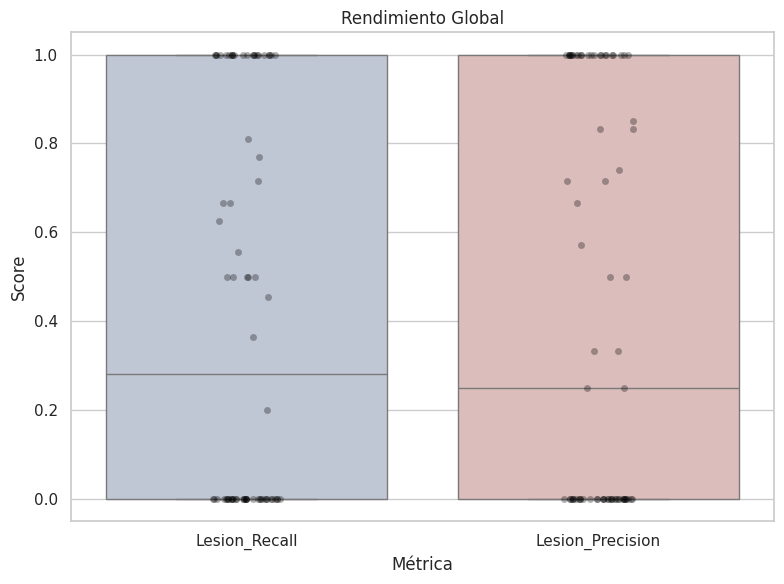

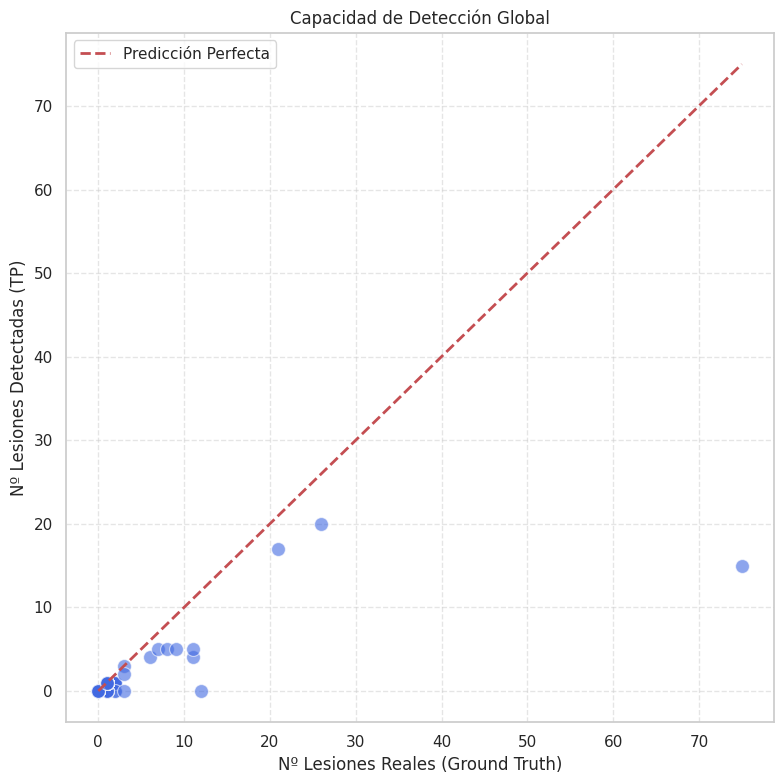

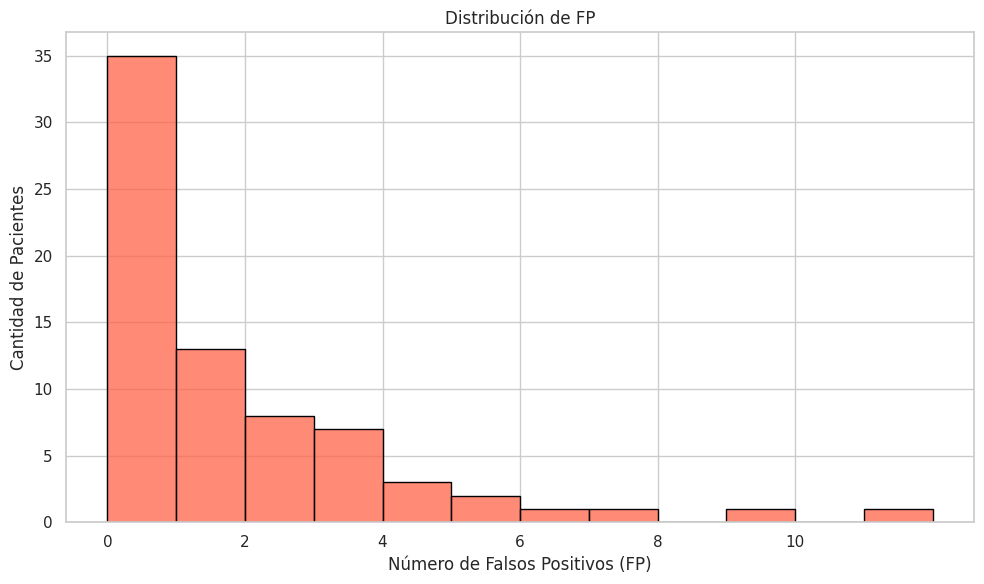

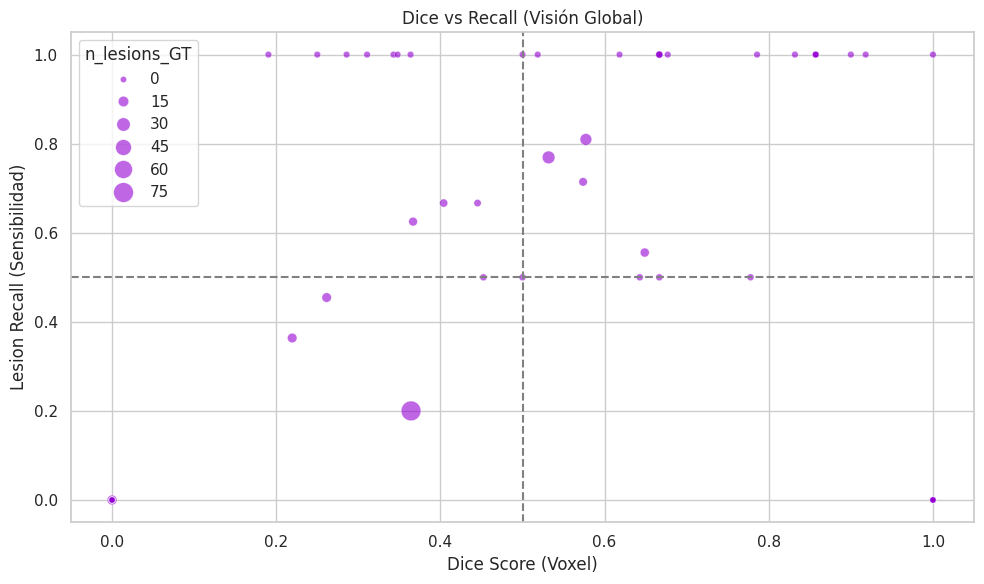

In [7]:
# =============================================================================
#           GRÁFICOS GLOBALES (SIN SEPARAR POR COHORTES)
# =============================================================================
print("\nGenerando gráficos globales (Figuras 5-8)...")

# FIGURA 5: Rendimiento Global (Cajas simples)
# Útil para ver la varianza general del modelo
plt.figure(figsize=(8, 6))
df_melt_global = df.melt(value_vars=['Lesion_Recall', 'Lesion_Precision'], 
                         var_name='Métrica', value_name='Score')
sns.boxplot(data=df_melt_global, x='Métrica', y='Score', palette="vlag")
sns.stripplot(data=df_melt_global, x='Métrica', y='Score', color='black', alpha=0.3, jitter=True) # Añade puntos reales
plt.title("Rendimiento Global")
plt.ylim(-0.05, 1.05)
plt.tight_layout()
plt.show()

# FIGURA 6: Detección Real vs Predicha (Scatter Global)
# Muestra si el modelo se satura sin importar el hospital
plt.figure(figsize=(8, 8))
sns.scatterplot(data=df, x='n_lesions_GT', y='TP', s=100, alpha=0.6, color='royalblue')

# Línea de identidad (Ideal)
max_val = max(df['n_lesions_GT'].max(), df['TP'].max())
plt.plot([0, max_val], [0, max_val], 'r--', linewidth=2, label='Predicción Perfecta')

plt.xlabel("Nº Lesiones Reales (Ground Truth)")
plt.ylabel("Nº Lesiones Detectadas (TP)")
plt.title("Capacidad de Detección Global")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# FIGURA 7: Histograma de Ruido (Falsos Positivos)
# Muestra la frecuencia: ¿Es normal tener 0 FP o es normal tener 5?
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='FP', bins=range(0, int(df['FP'].max()) + 2), kde=False, color='tomato', edgecolor='black')
plt.xlabel("Número de Falsos Positivos (FP)")
plt.ylabel("Cantidad de Pacientes")
plt.title("Distribución de FP")
plt.xticks(range(0, int(df['FP'].max()) + 1, 2)) # Eje X entero
plt.tight_layout()
plt.show()

# FIGURA 8: Dice vs Recall Global
# Para ver la nube de puntos general
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Dice_Voxel', y='Lesion_Recall', 
                size='n_lesions_GT', sizes=(20, 200), # Tamaño punto = nº lesiones reales
                alpha=0.6, color='darkviolet')
plt.axvline(0.5, color='gray', linestyle='--')
plt.axhline(0.5, color='gray', linestyle='--')
plt.xlabel("Dice Score (Voxel)")
plt.ylabel("Lesion Recall (Sensibilidad)")
plt.title("Dice vs Recall (Visión Global)")
plt.tight_layout()
plt.show()

Cargando datos de: metricas_globales_lesiones.csv ...
Total Lesiones: 239 (TP: 111 | FN: 128)


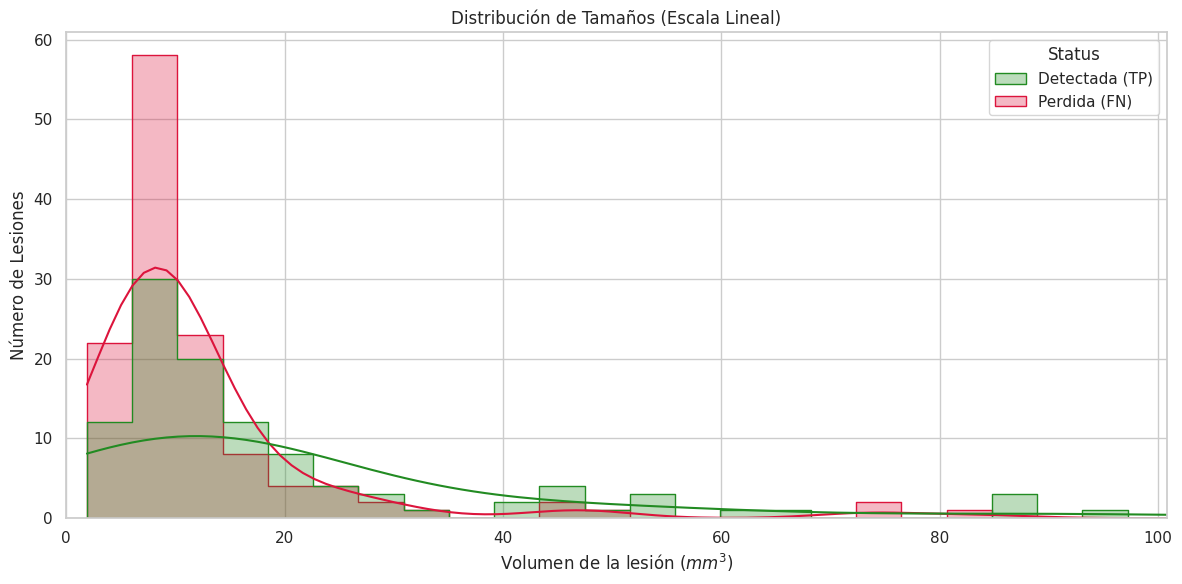

/tmp/ipykernel_297071/1785668162.py:71: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=bin_counts.index, y=bin_counts['Recall'], palette="Blues_d")


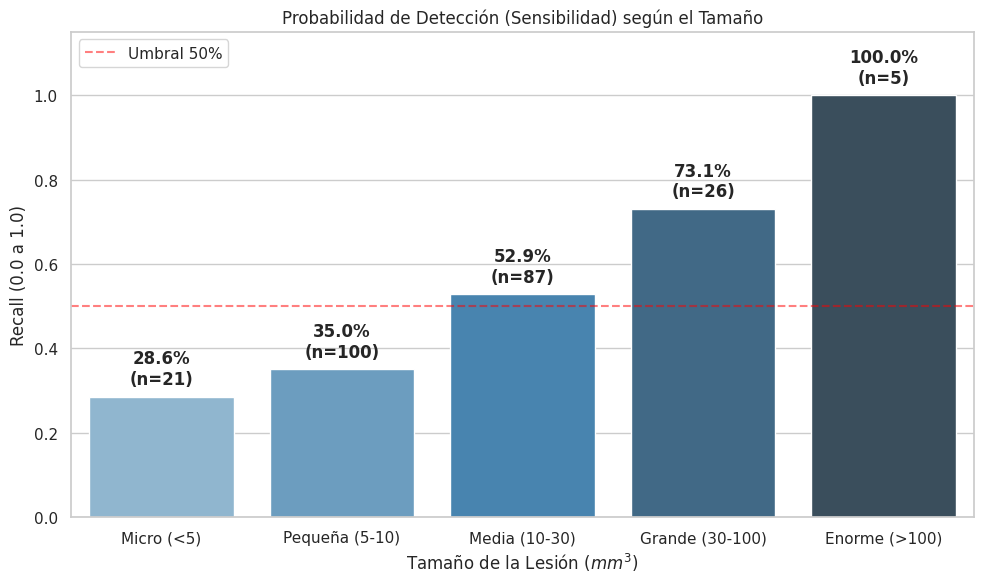

/tmp/ipykernel_297071/1785668162.py:89: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_vols, x='Status', y='Volume', palette={"Detectada (TP)": "forestgreen", "Perdida (FN)": "crimson"}, showfliers=False)


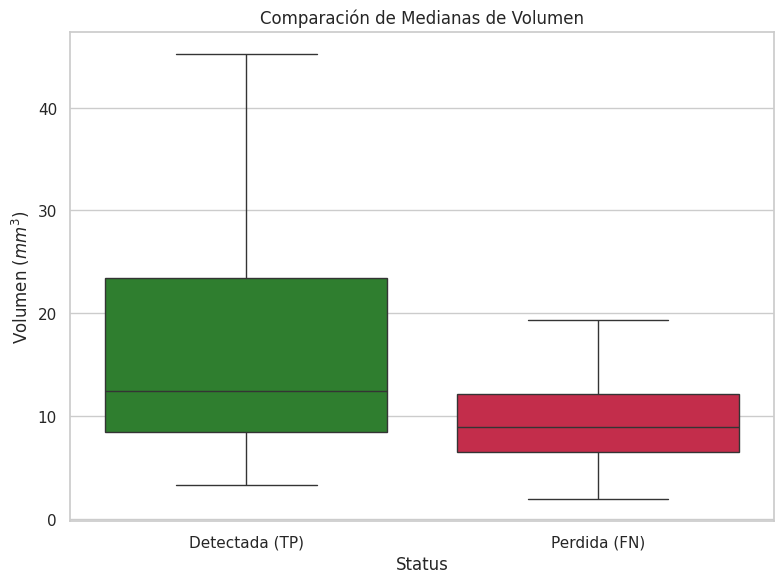

In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import numpy as np
import os

# --- CONFIGURACIÓN ---
input_csv = "metricas_globales_lesiones.csv"

if not os.path.exists(input_csv):
    print(f"ERROR: No encuentro '{input_csv}'.")
    exit()

print(f"Cargando datos de: {input_csv} ...")
df = pd.read_csv(input_csv)

# --- 1. LIMPIEZA DE DATOS ---
def parse_vol_list(vol_str):
    if pd.isna(vol_str) or str(vol_str).strip() == '[]': return []
    clean_str = re.sub(r'np\.float64\((.*?)\)', r'\1', str(vol_str))
    clean_str = clean_str.replace('[', '').replace(']', '').replace("'", "").replace('"', "")
    if not clean_str.strip(): return []
    try:
        return [float(x.strip()) for x in clean_str.split(',') if x.strip()]
    except:
        return []

detected_vols = []
missed_vols = []

for item in df['detected_vols']: detected_vols.extend(parse_vol_list(item))
for item in df['missed_vols']: missed_vols.extend(parse_vol_list(item))

df_vols = pd.DataFrame({
    'Volume': detected_vols + missed_vols,
    'Status': ['Detectada (TP)'] * len(detected_vols) + ['Perdida (FN)'] * len(missed_vols)
})

print(f"Total Lesiones: {len(df_vols)} (TP: {len(detected_vols)} | FN: {len(missed_vols)})")

# --- 2. GRÁFICOS (ESCALA LINEAL) ---
sns.set_theme(style="whitegrid")

# GRÁFICO A: Histograma Lineal
plt.figure(figsize=(12, 6))
sns.histplot(data=df_vols, x='Volume', hue='Status', 
             bins=50, # Más barras para ver detalle fino
             kde=True, element="step", 
             log_scale=False, # <--- CAMBIO AQUÍ: Escala Lineal
             palette={"Detectada (TP)": "forestgreen", "Perdida (FN)": "crimson"}, alpha=0.3)

plt.title("Distribución de Tamaños (Escala Lineal)")
plt.xlabel("Volumen de la lesión ($mm^3$)")
plt.ylabel("Número de Lesiones")
# Limitamos el eje X si hay algún outlier gigante que estropee la gráfica (opcional)
plt.xlim(0, df_vols['Volume'].quantile(0.98)) # Muestra hasta el percentil 98 para evitar espacios vacíos enormes
plt.tight_layout()
plt.show()

# GRÁFICO B: Tasa de Detección por Categoría (Igual que antes, muy útil)
bins = [0, 5, 10, 30, 100, 10000]
labels = ['Micro (<5)', 'Pequeña (5-10)', 'Media (10-30)', 'Grande (30-100)', 'Enorme (>100)']
df_vols['Size_Bin'] = pd.cut(df_vols['Volume'], bins=bins, labels=labels)

bin_counts = df_vols.groupby(['Size_Bin', 'Status'], observed=False).size().unstack(fill_value=0)
bin_counts['Total'] = bin_counts['Detectada (TP)'] + bin_counts['Perdida (FN)']
bin_counts['Recall'] = bin_counts.apply(lambda row: row['Detectada (TP)'] / row['Total'] if row['Total'] > 0 else 0, axis=1)

plt.figure(figsize=(10, 6))
ax = sns.barplot(x=bin_counts.index, y=bin_counts['Recall'], palette="Blues_d")
plt.title("Probabilidad de Detección (Sensibilidad) según el Tamaño")
plt.ylabel("Recall (0.0 a 1.0)")
plt.xlabel("Tamaño de la Lesión ($mm^3$)")
plt.ylim(0, 1.15)
plt.axhline(0.5, color='red', linestyle='--', alpha=0.5, label='Umbral 50%')

for i, v in enumerate(bin_counts['Recall']):
    total_n = bin_counts['Total'].iloc[i]
    if total_n > 0:
        ax.text(i, v + 0.02, f"{v:.1%}\n(n={total_n})", ha='center', va='bottom', fontweight='bold')

plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

# GRÁFICO C: Boxplot (También en lineal)
plt.figure(figsize=(8, 6))
sns.boxplot(data=df_vols, x='Status', y='Volume', palette={"Detectada (TP)": "forestgreen", "Perdida (FN)": "crimson"}, showfliers=False)
plt.title("Comparación de Medianas de Volumen")
plt.ylabel("Volumen ($mm^3$)")
plt.tight_layout()
plt.show()

In [ ]:
#### NUEVO CSV CON NUEVA COLUMNA: NÚM VOXELS EN GT
import pandas as pd
import nibabel as nib
import numpy as np
import os

# --- CONFIGURA ESTO ---
csv_path = "metricas_globales_lesiones.csv"
# Ruta donde están las etiquetas originales (Ground Truth)
# Ojo: Asegúrate de que apunta a la carpeta correcta donde están los .nii.gz
gt_folder = "/media/qubiotech/storage/DEEPLEARN/datasets/Neuro/CMB/nnUNet_raw/Dataset888_VALDO/labelsTr"

output_csv = "metricas_con_voxels.csv"

# ----------------------

if not os.path.exists(csv_path):
    print("No encuentro el CSV.")
    exit()

df = pd.read_csv(csv_path)
voxel_counts = []

print("Contando vóxeles en las máscaras originales...")

for case_id in df['case_id']:
    # Asumiendo que el nombre del archivo es case_id + ".nii.gz"
    # Si tus archivos tienen otro sufijo (ej. _0000), ajústalo aquí.
    mask_path = os.path.join(gt_folder, f"{case_id}.nii.gz")
    
    if os.path.exists(mask_path):
        try:
            nii = nib.load(mask_path)
            data = nii.get_fdata()
            # Contar vóxeles mayores a 0
            n_vox = np.sum(data > 0)
            voxel_counts.append(n_vox)
        except Exception as e:
            print(f"Error leyendo {case_id}: {e}")
            voxel_counts.append(None)
    else:
        print(f"Aviso: No encuentro imagen para {case_id}")
        voxel_counts.append(None)

df['n_voxels_GT'] = voxel_counts
df.to_csv(output_csv, index=False)
print(f"¡Hecho! Nuevo CSV guardado en: {output_csv}")

--- ESTADÍSTICAS ---
Total Pacientes: 72
Pacientes con Dice=0 (Fallos totales de localización): 28
Pacientes con Dice>0 (Aciertos de localización): 44
Dice Promedio Global (con ceros): 0.3867
Dice Promedio 'Real' (calidad de segmentación): 0.6328
Gráfico guardado en: distribucion_dice_sin_ceros.png


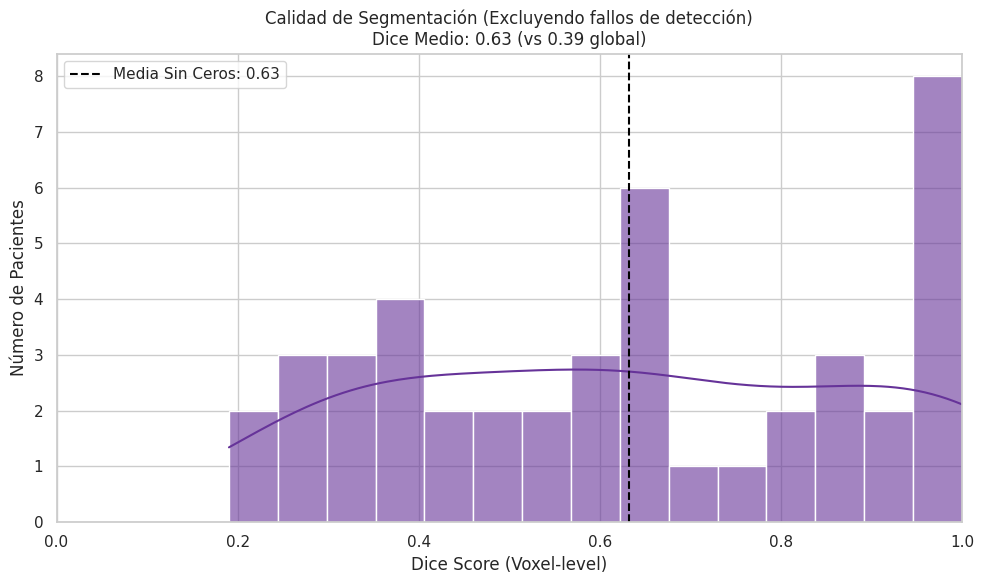

In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

# --- CONFIGURACIÓN ---
input_csv = "metricas_globales_lesiones.csv"
output_img = "distribucion_dice_sin_ceros.png"

if not os.path.exists(input_csv):
    print(f"ERROR: No encuentro {input_csv}")
    exit()

df = pd.read_csv(input_csv)

# Filtrar: Nos quedamos solo con los casos donde Dice > 0
# (Es decir, casos donde el modelo detectó ALGO y hubo solapamiento)
df_nonzero = df[df['Dice_Voxel'] > 0.001].copy()

# Datos estadísticos
mean_global = df['Dice_Voxel'].mean()
mean_condicional = df_nonzero['Dice_Voxel'].mean()
n_zeros = len(df) - len(df_nonzero)

print(f"--- ESTADÍSTICAS ---")
print(f"Total Pacientes: {len(df)}")
print(f"Pacientes con Dice=0 (Fallos totales de localización): {n_zeros}")
print(f"Pacientes con Dice>0 (Aciertos de localización): {len(df_nonzero)}")
print(f"Dice Promedio Global (con ceros): {mean_global:.4f}")
print(f"Dice Promedio 'Real' (calidad de segmentación): {mean_condicional:.4f}")

# Gráfico
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))

# Histograma con curva de densidad
sns.histplot(data=df_nonzero, x='Dice_Voxel', bins=15, kde=True, color='rebeccapurple', alpha=0.6)

plt.title(f"Calidad de Segmentación (Excluyendo fallos de detección)\nDice Medio: {mean_condicional:.2f} (vs {mean_global:.2f} global)")
plt.xlabel("Dice Score (Voxel-level)")
plt.ylabel("Número de Pacientes")
plt.xlim(0, 1.0)
plt.axvline(mean_condicional, color='black', linestyle='--', label=f"Media Sin Ceros: {mean_condicional:.2f}")

plt.legend()
plt.tight_layout()
plt.savefig(output_img)
print(f"Gráfico guardado en: {output_img}")
plt.show()

--- ESTADÍSTICAS ---
Total Pacientes: 72
Pacientes con Dice>0 (Aciertos de localización): 72
Dice Promedio Global (con ceros): 0.3867
Dice Promedio 'Real' (calidad de segmentación): 0.3867
Gráfico guardado en: distribucion_dice.png


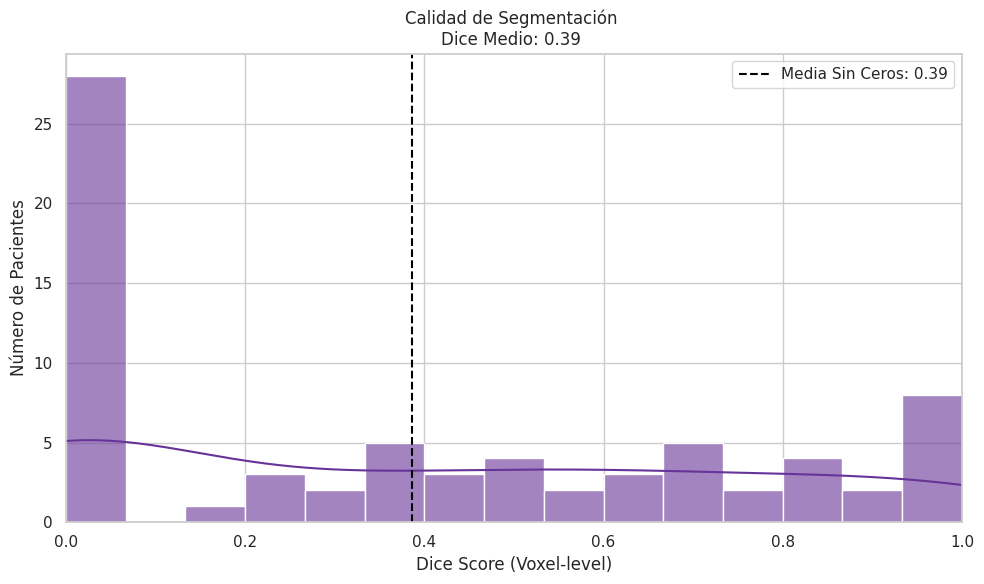

In [10]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

# --- CONFIGURACIÓN ---
input_csv = "metricas_globales_lesiones.csv"
output_img = "distribucion_dice.png"

if not os.path.exists(input_csv):
    print(f"ERROR: No encuentro {input_csv}")
    exit()

df = pd.read_csv(input_csv)


# Datos estadísticos
mean_global = df['Dice_Voxel'].mean()
mean_condicional = df['Dice_Voxel'].mean()

print(f"--- ESTADÍSTICAS ---")
print(f"Total Pacientes: {len(df)}")
print(f"Pacientes con Dice>0 (Aciertos de localización): {len(df)}")
print(f"Dice Promedio Global (con ceros): {mean_global:.4f}")
print(f"Dice Promedio 'Real' (calidad de segmentación): {mean_condicional:.4f}")

# Gráfico
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))

# Histograma con curva de densidad
sns.histplot(data=df, x='Dice_Voxel', bins=15, kde=True, color='rebeccapurple', alpha=0.6)

plt.title(f"Calidad de Segmentación \nDice Medio: {mean_condicional:.2f} ")
plt.xlabel("Dice Score (Voxel-level)")
plt.ylabel("Número de Pacientes")
plt.xlim(0, 1.0)
plt.axvline(mean_condicional, color='black', linestyle='--', label=f"Media Sin Ceros: {mean_condicional:.2f}")

plt.legend()
plt.tight_layout()
plt.savefig(output_img)
print(f"Gráfico guardado en: {output_img}")
plt.show()

--- RESULTADOS ---
Correlación de Spearman (No paramétrica): 0.056
P-valor: 7.013e-01
Gráfico guardado en: correlacion_voxels_dice.png


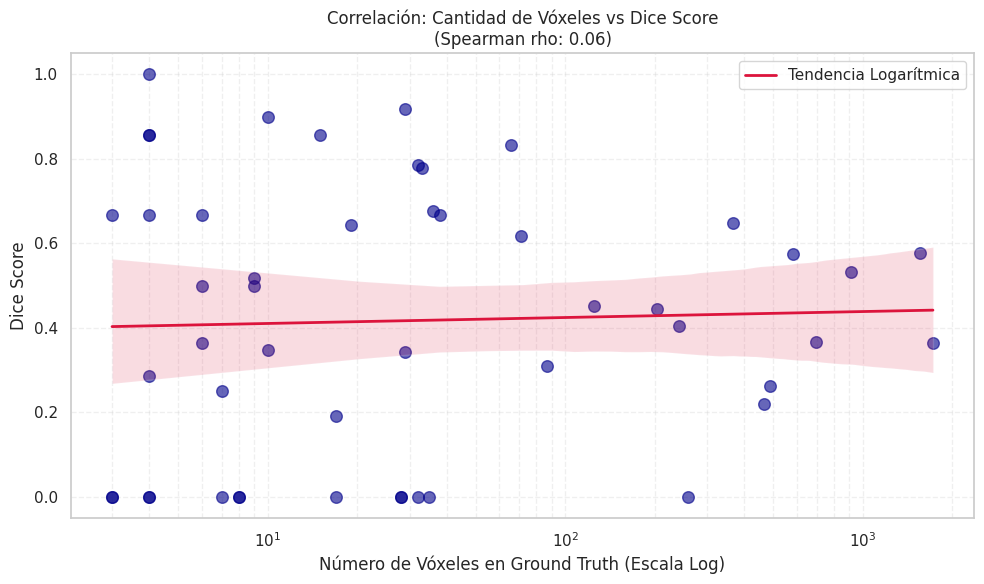

In [11]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
from scipy.stats import spearmanr

# --- CONFIGURACIÓN ---
input_csv = "metricas_con_voxels.csv" # El archivo nuevo que creaste
output_img = "correlacion_voxels_dice.png"

if not os.path.exists(input_csv):
    print(f"ERROR: No encuentro {input_csv}. ¿Ejecutaste el script anterior?")
    exit()

df = pd.read_csv(input_csv)

# Eliminar filas donde n_voxels_GT sea nulo o 0 (si las hubiera, para evitar errores log)
df = df.dropna(subset=['n_voxels_GT', 'Dice_Voxel'])
df = df[df['n_voxels_GT'] > 0]

# Calcular Correlación
corr, p_value = spearmanr(df['n_voxels_GT'], df['Dice_Voxel'])

print(f"--- RESULTADOS ---")
print(f"Correlación de Spearman (No paramétrica): {corr:.3f}")
print(f"P-valor: {p_value:.3e}")

# --- GRÁFICO ---
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))

# Usamos escala logarítmica en X porque suele haber mucha varianza en el nº de vóxeles
g = sns.regplot(data=df, x='n_voxels_GT', y='Dice_Voxel', logx=True,
                scatter_kws={'alpha':0.6, 's':70, 'color':'darkblue'},
                line_kws={'color':'crimson', 'linewidth':2, 'label':f'Tendencia Logarítmica'})

plt.title(f"Correlación: Cantidad de Vóxeles vs Dice Score\n(Spearman rho: {corr:.2f})")
plt.xlabel("Número de Vóxeles en Ground Truth (Escala Log)")
plt.ylabel("Dice Score")
plt.xscale('log') # Escala Log para ver mejor los pequeños vs gigantes
plt.grid(True, which="both", ls="--", alpha=0.3)
plt.legend()
plt.tight_layout()

plt.savefig(output_img)
print(f"Gráfico guardado en: {output_img}")
plt.show()

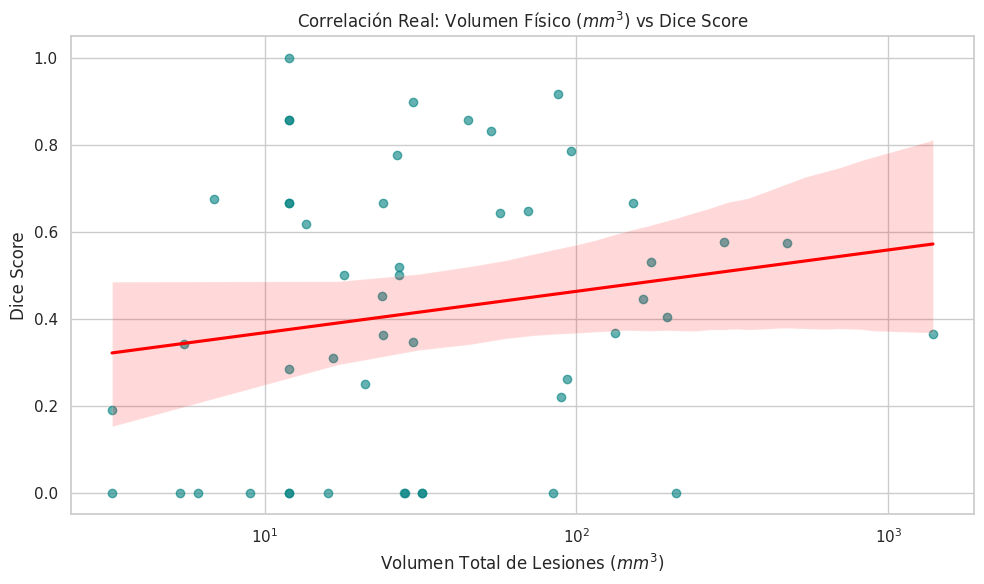

In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import numpy as np

# Cargar el CSV original (que tiene los volúmenes en mm3)
df = pd.read_csv('metricas_globales_lesiones.csv')

# Función para sumar las listas de texto (mm3)
def get_total_volume(row):
    # Parsea la lista de detectados
    str_det = str(row['detected_vols']).replace('np.float64(', '').replace(')', '').replace('[','').replace(']','')
    vols_det = [float(x) for x in str_det.split(',')] if str_det.strip() else []
    
    # Parsea la lista de perdidos
    str_miss = str(row['missed_vols']).replace('np.float64(', '').replace(')', '').replace('[','').replace(']','')
    vols_miss = [float(x) for x in str_miss.split(',')] if str_miss.strip() else []
    
    return sum(vols_det) + sum(vols_miss)

# Creamos la columna unificada
df['Total_Volume_mm3'] = df.apply(get_total_volume, axis=1)

# Filtramos ceros para limpiar el gráfico
df_clean = df[df['Total_Volume_mm3'] > 0]

# Gráfico
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))

# Usamos log scale porque hay lesiones gigantes y diminutas
sns.regplot(data=df_clean, x='Total_Volume_mm3', y='Dice_Voxel', logx=True,
            scatter_kws={'alpha':0.6, 'color':'teal'}, line_kws={'color':'red'})

plt.title("Correlación Real: Volumen Físico ($mm^3$) vs Dice Score")
plt.xlabel("Volumen Total de Lesiones ($mm^3$)")
plt.ylabel("Dice Score")
plt.xscale('log') 
plt.tight_layout()
plt.show()